# **Airbnb LA Market Analysis (2018–2021)**

## **Contents**

1. **Data Overview & Preprocessing**  
   1.1 Load & Transform Summary Dataset  
   1.2 Load & Clean Detailed Dataset  

2. **Exploratory Analysis**  
   2.1 Monthly Active Listings Over Time  
   2.2 Room Type Distribution Changes  
   2.3 Average Price Trends (2018–2021)  
   2.4 Neighborhood-Level Price Changes  
        2.4.1 All Neighborhoods (Full Sorted Comparison)  
        2.4.2 Top 20 Neighborhoods by Price Change  
        2.4.3 Priority Neighborhoods: Pandemic-Era Pricing Shifts  
   2.5 Cancellation Policy Distribution During COVID  
   2.6 Average Cleanliness Score Over Time  
   2.7 What Makes a Listing Successful?  
       2.7.1 Correlation Analysis Methodology  
       2.7.2 Correlation Analysis: Pre vs Post COVID


# **1. Data Overview & Preprocessing**

This project analyzes Airbnb listings in Los Angeles from March 2018 to January 2021, using two datasets from InsideAirbnb.com:

- **Summary Dataset:** Monthly snapshots with listing prices and neighborhood-level info. Used for time series analysis, segmentation, and pricing trend aggregation.
- **Detailed Dataset:** Rich listing-level metadata (host behavior, amenities, geolocation). Used for feature engineering and statistical profiling.

## **Why Segment by COVID Period?**

COVID-19 significantly disrupted the Airbnb market, especially in tourism-heavy cities like Los Angeles. We define two distinct market periods based on global travel shifts:

- **Pre-COVID:** Jan 1, 2018 – Feb 29, 2020  
- **Post-COVID:** Mar 1, 2020 – Jan 31, 2021

> 📌 **March 2020** marks the onset of widespread travel restrictions and listing volume collapse, as hosts either exited the platform or adapted strategies (e.g., switching to long-term rentals).

---

## **Note on Data Source**

Data is sourced from [InsideAirbnb.com](http://insideairbnb.com), which regularly scrapes Airbnb’s public listings. While not a live API, these structured snapshots offer a reliable basis for **longitudinal market analysis** and effectively simulate **passive web scraping**.

## **1.1 Load & Transform Summary Dataset**  

This section extracts pricing trends from the summary-level dataset by:

1. Keeping only `neighbourhood`, `price`, and `Scrape File`.
2. Parsing the scrape filename to extract year/month.
3. Creating a unified `scrape_date` field for monthly analysis.
4. Dropping temporary columns post-parsing.

This enables clean time series tracking of neighborhood-level average prices.

In [2]:
# Import Libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Mount Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [3]:
# Load summary dataset containing price, neighborhood, and scrape information
summary_df = pd.read_csv('/content/drive/MyDrive/AirBnB/Combined Listing Data [Summary].csv')

# Filter only relevant columns
summary_df = summary_df[['neighbourhood', 'price', 'Scrape File']]

# Extract year and month using regex
summary_df['year'] = summary_df['Scrape File'].str.extract(r'_(\d{4})_')[0]
summary_df['month'] = summary_df['Scrape File'].str.extract(r'_(\d{4})_(\d{2})_')[1]

# Convert to datetime format
summary_df['scrape_date'] = pd.to_datetime(summary_df['year'] + '-' + summary_df['month'] + '-01')

# Drop unnecessary columns if needed
summary_df.drop(columns=['year', 'month'], inplace=True)

# Display the first few rows of the filtered dataframe
display(summary_df.head())


/tmp/ipython-input-3-590736503.py:2: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  summary_df = pd.read_csv('/content/drive/MyDrive/AirBnB/Combined Listing Data [Summary].csv')


,neighbourhood,price,Scrape File,scrape_date
0,Venice,145,los_angeles_2015_05_listings.csv,2015-05-01
1,Venice,175,los_angeles_2015_05_listings.csv,2015-05-01
2,Rancho Palos Verdes,295,los_angeles_2015_05_listings.csv,2015-05-01
3,Hollywood,110,los_angeles_2015_05_listings.csv,2015-05-01
4,Venice,600,los_angeles_2015_05_listings.csv,2015-05-01


## **1.2 Load & Clean Detailed Dataset**  

This section loads the detailed listing-level dataset prepared for modeling and COVID-era segmentation.

Key steps (performed during earlier preprocessing):
- **Column Selection:** Host, listing, and review metadata.
- **Data Cleaning:** Converted prices/dates/percentages, imputed missing values.
- **Feature Engineering:** Parsed bathroom info, grouped cancellation policies, cleaned geolocation fields.
- **Segmentation:** Data split into pre- and post-COVID periods for downstream analysis.

> **Note:** While the `price` column exists in the detailed dataset, it was excluded from modeling due to missingness and inconsistencies. The summary dataset is used for reliable pricing insights.

The cleaned dataset is reloaded from Drive for efficient downstream analysis.

In [4]:
# # Read only the specified columns to optimize memory usage
# df = pd.read_csv('/content/drive/MyDrive/AirBnB/Combined Listing Data [Detailed].csv',low_memory=False)

In [5]:
# # Step 1: Data Cleaning and Transformation

# # Create a new DataFrame with relevant columns for analysis
# clean_df = df[['id', 'last_scraped', 'price', 'availability_365', 'reviews_per_month',
#                         'room_type', 'neighbourhood_cleansed', 'latitude', 'longitude', 'bathrooms_text',
#                         'minimum_nights', 'calculated_host_listings_count', 'number_of_reviews',
#                         'instant_bookable', 'cancellation_policy',
#                         'host_is_superhost', 'host_response_rate', 'host_acceptance_rate',
#                         'property_type', 'accommodates',
#                         'review_scores_rating', 'review_scores_cleanliness',
#                         'review_scores_location', 'review_scores_value',
#                         'review_scores_communication']]

# # Convert 'last_scraped' to datetime and clean the 'price' column
# clean_df['last_scraped'] = pd.to_datetime(clean_df['last_scraped'], errors='coerce')
# clean_df['price'] = clean_df['price'].replace('[\$,]', '', regex=True).astype(float)

# # Fill missing values for relevant columns
# clean_df['reviews_per_month'] = clean_df['reviews_per_month'].fillna(0)
# clean_df['bathrooms_text'] = clean_df['bathrooms_text'].fillna('unknown')

# # Add time-based columns for year and month from 'last_scraped'
# clean_df['year'] = clean_df['last_scraped'].dt.year
# clean_df['month'] = clean_df['last_scraped'].dt.month

# # Step 2: Handle latitude and longitude
# # Convert latitude and longitude to numeric, forcing errors to NaN
# clean_df['latitude'] = pd.to_numeric(clean_df['latitude'], errors='coerce')
# clean_df['longitude'] = pd.to_numeric(clean_df['longitude'], errors='coerce')

# # Check for NaN values in latitude and longitude and handle them
# clean_df['latitude'].fillna(0, inplace=True)
# clean_df['longitude'].fillna(0, inplace=True)

# # Step 3: Convert relevant columns to numeric
# clean_df['availability_365'] = pd.to_numeric(clean_df['availability_365'], errors='coerce')
# clean_df['minimum_nights'] = pd.to_numeric(clean_df['minimum_nights'], errors='coerce')
# clean_df['number_of_reviews'] = pd.to_numeric(clean_df['number_of_reviews'], errors='coerce')
# clean_df['accommodates'] = pd.to_numeric(clean_df['accommodates'], errors='coerce')

# # Verify conversion and check data types
# print(clean_df.dtypes)
# display(clean_df.head())

# # Step 4: Review Scores and other features handling
# # Handling percentages (host response and acceptance rates)
# clean_df['host_response_rate'] = clean_df['host_response_rate'].str.rstrip('%').astype('float') / 100
# clean_df['host_acceptance_rate'] = clean_df['host_acceptance_rate'].str.rstrip('%').astype('float') / 100

# # Fill missing review scores with 0
# review_score_columns = ['review_scores_rating', 'review_scores_cleanliness',
#                         'review_scores_location', 'review_scores_value',
#                         'review_scores_communication']
# clean_df[review_score_columns] = clean_df[review_score_columns].fillna(0)

# # Step 5: Extract Number of Bathrooms from 'bathrooms_text' using regex
# import re

# def extract_num_bathrooms(bathroom_text):
#     match = re.search(r'\d+\.?\d*', str(bathroom_text))
#     return float(match.group(0)) if match else None

# clean_df['num_bathrooms'] = clean_df['bathrooms_text'].apply(extract_num_bathrooms)

# # Step 6: Determine bathroom type (shared or private)
# clean_df['bathroom_type'] = clean_df['bathrooms_text'].apply(lambda x: 'shared' if 'shared' in x else ('unknown' if x == 'unknown' else 'private'))

# # Step 7: Round latitude and longitude to 5 decimal places for consistency
# clean_df['latitude'] = clean_df['latitude'].round(5)
# clean_df['longitude'] = clean_df['longitude'].round(5)

# # Step 8: Mapping cancellation policies to broader categories
# cancellation_policy_mapping = {
#    'flexible': 'Flexible',
#    'moderate': 'Moderate',
#    'strict': 'Strict',
#    'strict_14_with_grace_period': 'Strict',
#    'super_strict_60': 'Super Strict',
#    'super_strict_30': 'Super Strict',
#    'luxury_moderate': 'Moderate',
#    'luxury_super_strict_95': 'Super Strict',
#    'unknown': 'Other'  # Changed to 'Other'
# }

# # Ensure cancellation policy is mapped to new column
# clean_df['cancellation_policy_cleaned'] = clean_df['cancellation_policy'].map(cancellation_policy_mapping).fillna('Other')


In [6]:
# # Step 1: Handle Missing Data

# # Fill missing values in specific columns
# clean_df['availability_365'] = clean_df['availability_365'].fillna(0)  # Assume unavailable listings
# clean_df['minimum_nights'] = clean_df['minimum_nights'].fillna(1)  # Assume most listings require at least 1 night
# clean_df['cancellation_policy'] = clean_df['cancellation_policy'].fillna('unknown')
# clean_df['host_is_superhost'] = clean_df['host_is_superhost'].fillna('f')  # Default to 'not a superhost'
# clean_df['num_bathrooms'] = clean_df['num_bathrooms'].fillna('unknown')  # Fill with 'unknown' for missing bathroom info

# # Fill missing review scores with 0
# review_score_columns = ['review_scores_rating', 'review_scores_cleanliness', 'review_scores_location',
#                         'review_scores_value', 'review_scores_communication']
# clean_df[review_score_columns] = clean_df[review_score_columns].fillna(0)

# # Fill missing numerical values with median (or mean for rate columns)
# clean_df['price'] = clean_df['price'].fillna(clean_df['price'].median())
# clean_df['calculated_host_listings_count'] = clean_df['calculated_host_listings_count'].fillna(clean_df['calculated_host_listings_count'].median())
# clean_df['number_of_reviews'] = clean_df['number_of_reviews'].fillna(clean_df['number_of_reviews'].median())

# # Fill categorical columns with mode (most frequent value)
# clean_df['room_type'] = clean_df['room_type'].fillna(clean_df['room_type'].mode()[0])
# clean_df['instant_bookable'] = clean_df['instant_bookable'].fillna(clean_df['instant_bookable'].mode()[0])

# # For host response and acceptance rates, fill missing values with mean (calculated from existing data)
# clean_df['host_response_rate'] = clean_df['host_response_rate'].fillna(clean_df['host_response_rate'].mean())
# clean_df['host_acceptance_rate'] = clean_df['host_acceptance_rate'].fillna(clean_df['host_acceptance_rate'].mean())

# # Step 2: Check if there are any remaining missing values
# print(clean_df.isnull().sum())  # Verify all missing data has been handled

# # Display the cleaned dataframe and verify changes
# display(clean_df.head())


In [7]:
# # Define the save path in Google Drive
# output_path = '/content/drive/MyDrive/Cleaned_Listing_Data_File_2.csv'

# # Save the cleaned dataset as a CSV file
# clean_df.to_csv(output_path, index=False)

# print(f"Cleaned dataset saved to: {output_path}")

In [8]:
# Load cleaned detailed dataset (preprocessed and saved earlier)
clean_df = pd.read_csv('/content/drive/MyDrive/Cleaned_Listing_Data_File_2.csv')

# Segment data into pre- and post-COVID windows for comparative analysis
pre_covid_df = clean_df[(clean_df['last_scraped'] >= '2018-01-01') & (clean_df['last_scraped'] <= '2020-02-29')]
post_covid_df = clean_df[(clean_df['last_scraped'] >= '2020-03-01') & (clean_df['last_scraped'] <= '2021-01-31')]

# Display sample records for verification
display(pre_covid_df.head())
display(post_covid_df.head())

/tmp/ipython-input-8-1621055688.py:2: DtypeWarning: Columns (0,14) have mixed types. Specify dtype option on import or set low_memory=False.
  clean_df = pd.read_csv('/content/drive/MyDrive/Cleaned_Listing_Data_File_2.csv')


,id,last_scraped,price,availability_365,reviews_per_month,room_type,neighbourhood_cleansed,latitude,longitude,bathrooms_text,...,review_scores_rating,review_scores_cleanliness,review_scores_location,review_scores_value,review_scores_communication,year,month,num_bathrooms,bathroom_type,cancellation_policy_cleaned
213861,109,2018-03-08,122.0,344.0,0.03,Entire home/apt,Culver City,33.98209,-118.38494,unknown,...,80.0,10.0,10.0,8.0,8.0,2018.0,3.0,NaN,unknown,Strict
213862,344,2018-03-08,168.0,0.0,0.05,Entire home/apt,Burbank,34.16562,-118.33458,unknown,...,80.0,10.0,10.0,8.0,10.0,2018.0,3.0,NaN,unknown,Flexible
213863,2404,2018-03-07,85.0,365.0,0.00,Shared room,Del Rey,33.98464,-118.44006,unknown,...,0.0,0.0,0.0,0.0,0.0,2018.0,3.0,NaN,unknown,Moderate
213864,2732,2018-03-07,155.0,313.0,0.21,Private room,Santa Monica,34.00475,-118.48127,unknown,...,96.0,9.0,10.0,9.0,10.0,2018.0,3.0,NaN,unknown,Strict
213865,2864,2018-03-07,80.0,0.0,0.00,Entire home/apt,Bellflower,33.87619,-118.11397,unknown,...,0.0,0.0,0.0,0.0,0.0,2018.0,3.0,NaN,unknown,Strict


,id,last_scraped,price,availability_365,reviews_per_month,room_type,neighbourhood_cleansed,latitude,longitude,bathrooms_text,...,review_scores_rating,review_scores_cleanliness,review_scores_location,review_scores_value,review_scores_communication,year,month,num_bathrooms,bathroom_type,cancellation_policy_cleaned
1228912,109,2020-03-14,122.0,0.0,0.02,Entire home/apt,Culver City,33.98209,-118.38494,unknown,...,80.0,10.0,10.0,8.0,8.0,2020.0,3.0,NaN,unknown,Strict
1228913,344,2020-03-14,168.0,138.0,0.18,Entire home/apt,Burbank,34.16562,-118.33458,unknown,...,97.0,10.0,10.0,10.0,10.0,2020.0,3.0,NaN,unknown,Flexible
1228914,2708,2020-03-14,79.0,332.0,0.33,Private room,Hollywood,34.09768,-118.34602,unknown,...,98.0,10.0,10.0,10.0,10.0,2020.0,3.0,NaN,unknown,Strict
1228915,2732,2020-03-14,155.0,365.0,0.20,Private room,Santa Monica,34.00475,-118.48127,unknown,...,94.0,9.0,10.0,9.0,9.0,2020.0,3.0,NaN,unknown,Strict
1228916,2864,2020-03-14,80.0,0.0,0.00,Entire home/apt,Bellflower,33.87619,-118.11397,unknown,...,0.0,0.0,0.0,0.0,0.0,2020.0,3.0,NaN,unknown,Strict


# **2. Exploratory Analysis**

## **2.1 Monthly Active Listings Over Time**

This section tracks how Airbnb listing supply in Los Angeles evolved from 2018 to 2021, with special attention to the impact of COVID-19.

**1. Pre-COVID Growth (Jan 2018 – Oct 2019)**

  Airbnb listings steadily increased throughout 2018 and 2019, peaking around **October 2019**. This rise was driven by strong tourism demand and increasing adoption of short-term rental hosting across LA neighborhoods.

**2. Early Decline & Transition Period (Nov 2019 – Feb 2020)**

  Listing volume began declining **prior to the formal onset of the COVID-19 pandemic**, with visible drops starting **December 2019**. This early contraction may reflect rising global uncertainty, travel hesitation, and seasonal slowdown — rather than direct regulatory or pandemic impacts. Although the City of LA implemented the **Home Sharing Ordinance** in **July 2019**, its effect appears limited compared to the broader macro uncertainty at the time.

**3. Post-COVID Contraction (Mar 2020 – Jan 2021)**

  From March 2020 onward, listings declined sharply — aligning with **global lockdowns and travel bans**. The supply shock was driven by:
  - Hosts delisting properties due to safety and demand collapse
  - A shift toward long-term rentals
  - Heightened financial uncertainty

Listing numbers reached a low point in **late 2020**, stabilizing slightly by early 2021 but remaining well below pre-pandemic levels. This trend reflects a **pandemic-driven market correction** on the supply side, with broader implications for availability, competition, and pricing power in LA’s short-term rental economy.


/tmp/ipython-input-9-490302672.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pre_covid_df['last_scraped'] = pd.to_datetime(pre_covid_df['last_scraped'])
/tmp/ipython-input-9-490302672.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  post_covid_df['last_scraped'] = pd.to_datetime(post_covid_df['last_scraped'])
/tmp/ipython-input-9-490302672.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  pre_monthly = pre_covid_df.groupby(pd.Grouper(key='las

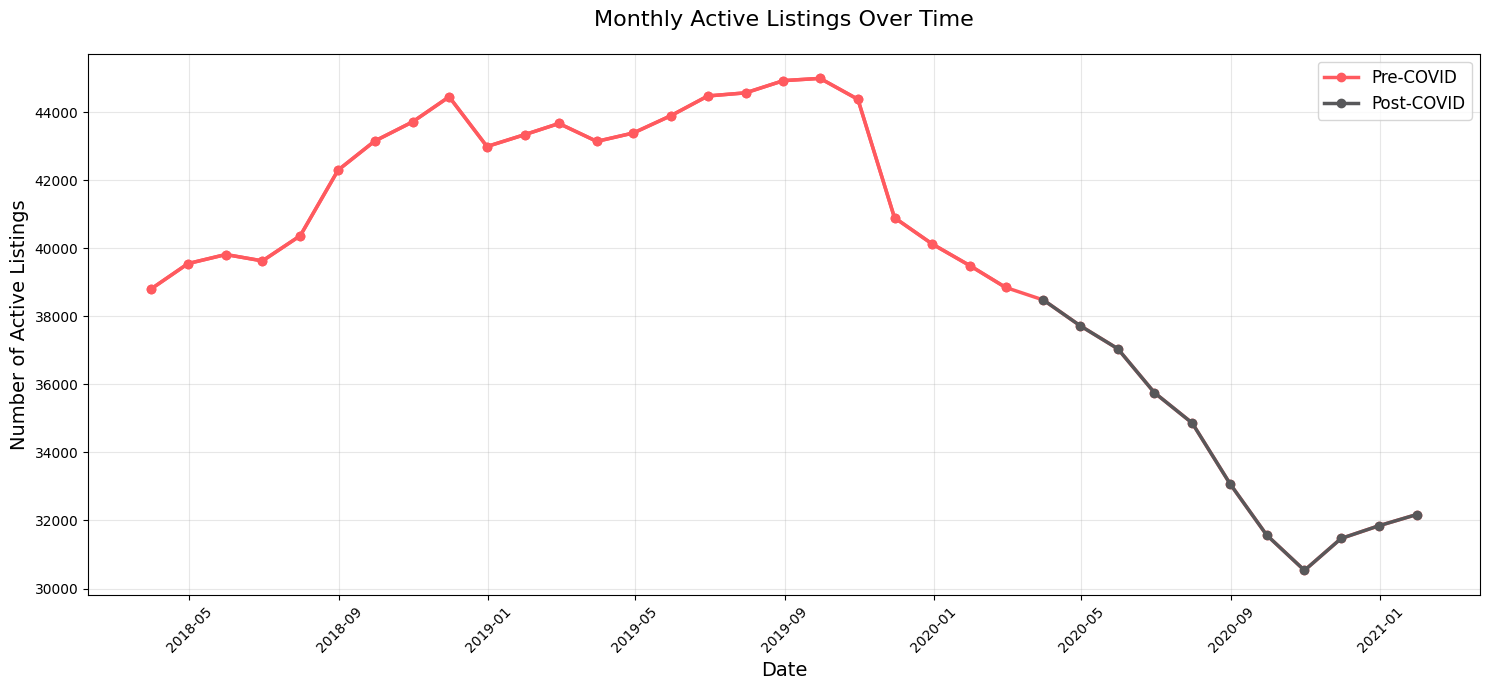


Summary Statistics:
Pre-COVID average listings: 42290
Post-COVID average listings: 34050
Maximum listings: 44995
Minimum listings (post-COVID): 30533

Percent change from peak to post-COVID low: -32.1%


In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert last_scraped to datetime
pre_covid_df['last_scraped'] = pd.to_datetime(pre_covid_df['last_scraped'])
post_covid_df['last_scraped'] = pd.to_datetime(post_covid_df['last_scraped'])

# Create monthly counts for pre and post COVID periods
pre_monthly = pre_covid_df.groupby(pd.Grouper(key='last_scraped', freq='M')).size().reset_index()
post_monthly = post_covid_df.groupby(pd.Grouper(key='last_scraped', freq='M')).size().reset_index()
pre_monthly.columns = ['date', 'count']
post_monthly.columns = ['date', 'count']

# Combine into one continuous timeline
all_monthly = pd.concat([pre_monthly, post_monthly]).sort_values('date')

# Create the plot
plt.figure(figsize=(15, 7))

# Plot the entire line first
plt.plot(all_monthly['date'], all_monthly['count'],
         color='#FF5A5F', linewidth=2.5, marker='o')

# Color the segments differently
covid_start = pd.to_datetime('2020-02-01')
plt.plot(pre_monthly['date'], pre_monthly['count'],
         color='#FF5A5F', linewidth=2.5, marker='o', label='Pre-COVID')
plt.plot(post_monthly['date'], post_monthly['count'],
         color='#58585A', linewidth=2.5, marker='o', label='Post-COVID')

# Customize the plot
plt.title('Monthly Active Listings Over Time', pad=20, fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Number of Active Listings', fontsize=14)

# Format axes
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Add legend
plt.legend(fontsize=12)

# Annotate peak
max_count = all_monthly['count'].max()
max_date = all_monthly.loc[all_monthly['count'].idxmax(), 'date']

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary Statistics:")
print(f"Pre-COVID average listings: {pre_monthly['count'].mean():.0f}")
print(f"Post-COVID average listings: {post_monthly['count'].mean():.0f}")
print(f"Maximum listings: {max_count:.0f}")
print(f"Minimum listings (post-COVID): {post_monthly['count'].min():.0f}")
print(f"\nPercent change from peak to post-COVID low: {((post_monthly['count'].min() - max_count) / max_count * 100):.1f}%")

## **2.2 Room Type Distribution Changes**

This visualization compares the percentage distribution of room types listed on Airbnb in Los Angeles before and after the onset of COVID-19.

**Key Trends:**
- **Entire home/apt** listings increased slightly from **62.1% → 63.7%**, reflecting a shift in guest preference toward private, isolated stays during the pandemic.
- **Private room** listings decreased marginally from **33.5% → 32.4%**, likely due to reduced demand for shared-living arrangements.
- **Shared room** listings saw a notable drop from **4.2% → 3.5%**, reinforcing the decline in interest for communal accommodation amidst public health concerns.
- **Hotel room** listings, though minimal, increased from **0.2% → 0.5%**, potentially due to small-scale hotels listing on Airbnb to offset traditional booking declines.


COVID-19 prompted a clear **supply-side shift toward full-unit rentals** and away from shared spaces. This reflects both **health-driven consumer behavior** and strategic host repositioning to meet evolving guest expectations for privacy and safety.

Overall, the data signals Airbnb's adaptation to a more **individualized, health-conscious travel environment**.


/tmp/ipython-input-10-3225915518.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(i - bar_width/2, room_dist_df['Pre-COVID (%)'][i] + 1,
/tmp/ipython-input-10-3225915518.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f"{room_dist_df['Pre-COVID (%)'][i]:.1f}%",
/tmp/ipython-input-10-3225915518.py:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(i + bar_width/2, room_dist_df['Post-COVID (%)'][i] + 1,
/tmp/

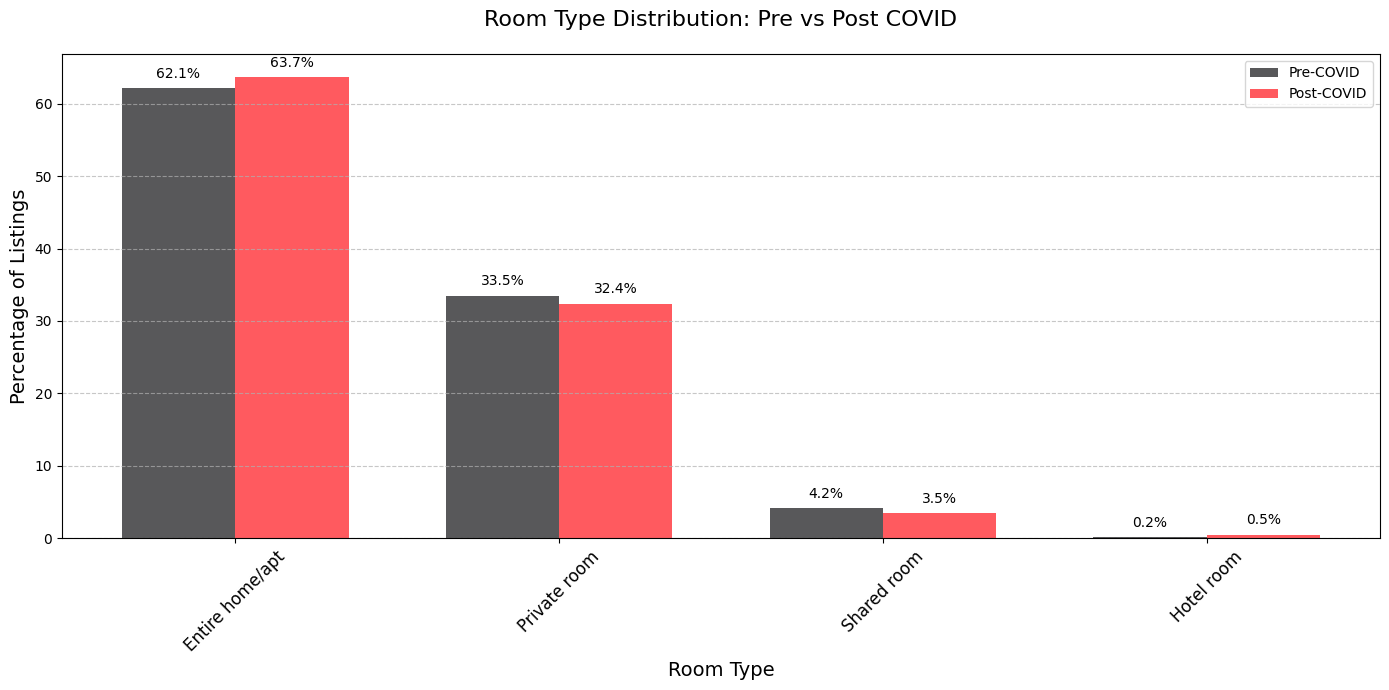

In [10]:
# Room Type Distribution Pre vs Post COVID
pre_room_dist = pre_covid_df['room_type'].value_counts(normalize=True) * 100
post_room_dist = post_covid_df['room_type'].value_counts(normalize=True) * 100

# Create comparison DataFrame
room_dist_df = pd.DataFrame({
    'Pre-COVID (%)': pre_room_dist,
    'Post-COVID (%)': post_room_dist
}).round(1)

# Create the plot
plt.figure(figsize=(14, 7))
bar_width = 0.35
x = np.arange(len(room_dist_df.index))

# Plotting the bars
plt.bar(x - bar_width/2, room_dist_df['Pre-COVID (%)'],
        bar_width, label='Pre-COVID', color='#58585A')  # Dark Grey for Pre-COVID
plt.bar(x + bar_width/2, room_dist_df['Post-COVID (%)'],
        bar_width, label='Post-COVID', color='#FF5A5F')  # Airbnb Red for Post-COVID

# Title, labels, and grid
plt.title('Room Type Distribution: Pre vs Post COVID', pad=20, fontsize=16)
plt.xlabel('Room Type', fontsize=14)
plt.ylabel('Percentage of Listings', fontsize=14)
plt.xticks(x, room_dist_df.index, rotation=45, fontsize=12)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add percentage labels on top of the bars
for i in x:
    plt.text(i - bar_width/2, room_dist_df['Pre-COVID (%)'][i] + 1,
             f"{room_dist_df['Pre-COVID (%)'][i]:.1f}%",
             ha='center', va='bottom', fontsize=10)
    plt.text(i + bar_width/2, room_dist_df['Post-COVID (%)'][i] + 1,
             f"{room_dist_df['Post-COVID (%)'][i]:.1f}%",
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


## **2.3 Average Price Trends (2018–2021)**

This analysis tracks the evolution of Airbnb listing prices in Los Angeles from 2018 through early 2021.

**Key Trends:**
- **Steady Growth Pre-COVID:** Prices climbed from ~\$194 in early 2018 to a peak of **\$234.57** by early 2020—likely fueled by rising tourism demand and seasonal pricing.
- **Post-COVID Resilience:** Despite a steep drop in listing volume, **average prices remained elevated** during the pandemic. This suggests:
  - Lower-priced units may have exited the platform.
  - Remaining supply skewed toward higher-end listings.
- **Moderate Decline:** A dip followed the peak, hitting a post-COVID low of **\$218.91**, representing a **-6.7% decline from peak**.


While **demand dropped**, average listing prices **remained robust**, suggesting Airbnb hosts adapted by removing budget listings or capitalizing on travelers’ preference for premium, private stays. This reflects a **supply-side rebalancing** rather than a market-wide price collapse.


/tmp/ipython-input-11-904642391.py:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  pre_monthly = pre_cov.groupby(pd.Grouper(key='scrape_date', freq='M'))['price'].mean().reset_index()
/tmp/ipython-input-11-904642391.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  post_monthly = post_cov.groupby(pd.Grouper(key='scrape_date', freq='M'))['price'].mean().reset_index()


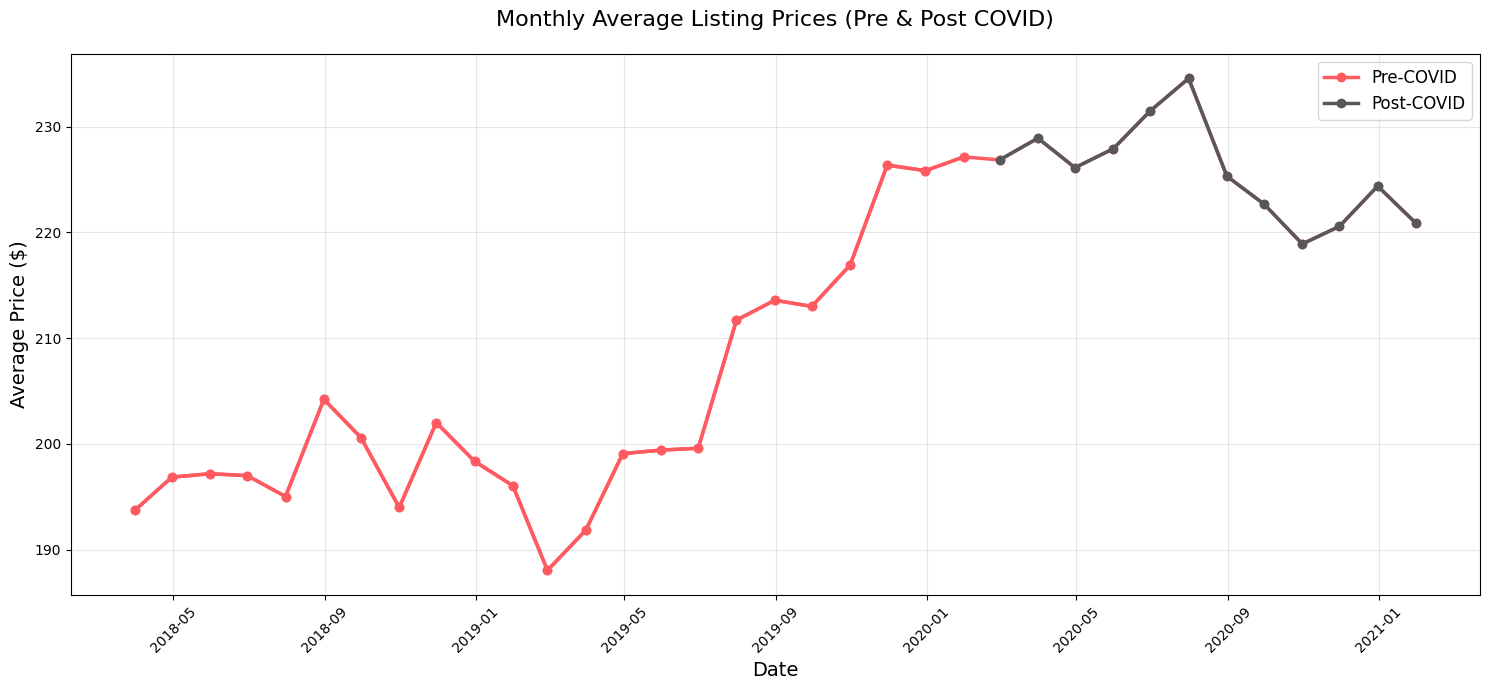


Summary Statistics:
Pre-COVID average price: $203.80
Post-COVID average price: $225.72
Maximum price: $234.57
Minimum price (post-COVID): $218.91

Percent change from peak to post-COVID low: -6.7%


In [11]:
import matplotlib.pyplot as plt
import pandas as pd


# Define pre and post COVID periods
pre_cov = summary_df[(summary_df['scrape_date'] >= '2018-01-01') & (summary_df['scrape_date'] <= '2020-01-31')]
post_cov = summary_df[(summary_df['scrape_date'] >= '2020-02-01') & (summary_df['scrape_date'] <= '2021-01-31')]

# Create monthly averages for pre and post COVID periods
pre_monthly = pre_cov.groupby(pd.Grouper(key='scrape_date', freq='M'))['price'].mean().reset_index()
post_monthly = post_cov.groupby(pd.Grouper(key='scrape_date', freq='M'))['price'].mean().reset_index()

# Combine into one continuous timeline
all_monthly = pd.concat([pre_monthly, post_monthly]).sort_values('scrape_date')

# Create the plot
plt.figure(figsize=(15, 7))

# Plot the entire line
plt.plot(all_monthly['scrape_date'], all_monthly['price'],
         color='#FF5A5F', linewidth=2.5, marker='o')

# Color the segments differently
plt.plot(pre_monthly['scrape_date'], pre_monthly['price'],
         color='#FF5A5F', linewidth=2.5, marker='o', label='Pre-COVID')
plt.plot(post_monthly['scrape_date'], post_monthly['price'],
         color='#58585A', linewidth=2.5, marker='o', label='Post-COVID')

# Customize the plot
plt.title('Monthly Average Listing Prices (Pre & Post COVID)', pad=20, fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Average Price ($)', fontsize=14)

# Format axes
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Add legend
plt.legend(fontsize=12)

# Annotate peak
max_price = all_monthly['price'].max()
max_date = all_monthly.loc[all_monthly['price'].idxmax(), 'scrape_date']

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary Statistics:")
print(f"Pre-COVID average price: ${pre_monthly['price'].mean():.2f}")
print(f"Post-COVID average price: ${post_monthly['price'].mean():.2f}")
print(f"Maximum price: ${max_price:.2f}")
print(f"Minimum price (post-COVID): ${post_monthly['price'].min():.2f}")
print(f"\nPercent change from peak to post-COVID low: {((post_monthly['price'].min() - max_price) / max_price * 100):.1f}%")


## **2.4 Neighborhood-Level Price Changes**

This section begins with a full comparison across all neighborhoods (**2.4.1**), followed by a focused view of the **top 20 neighborhoods** with the largest absolute price increases (**2.4.2**) and a zoomed-in analysis of **12 high-priority areas** commonly featured in LA Airbnb searches (**2.4.3**).



### **2.4.1 All Neighborhoods (Full Sorted Comparison)**

- **Luxury surges**: Hidden Hills, Rolling Hills, and Bel-Air led with increases ranging around **\$750 to \$4,000**, driven by rising demand for **secluded, high-end rentals** during the pandemic.

- **Affordable market acceleration**: Neighborhoods like **Florence-Firestone** and **Southeast Antelope Valley** saw **300–500%+ price growth**. These areas started with low average prices (e.g., \$70–\$120), but saw **significant absolute increases** as Airbnb expanded into **formerly overlooked, affordable zones** where demand surged and hosts capitalized on new rental opportunities.

- **Urban moderation**: Central areas like **Venice**, **Downtown**, and **Koreatown** saw **modest, positive price shifts** (typically **\$30–\$60**), reflecting **resilient demand** even amid ongoing travel restrictions.

- **Declines concentrated in**: Tourist-reliant or underserved neighborhoods such as **Harvard Park (-54%)**, **East Pasadena (-23%)**, and **Bradbury (-75%)** saw steep drops, likely due to **reduced travel demand** or **oversupply of listings** during the pandemic.

This table supports **targeted Airbnb strategy** across luxury destinations, rising affordable areas, and stabilized urban cores.


In [12]:
# Helper: Calculate price changes by neighborhood
def get_neighborhood_price_change(pre_df, post_df, neighborhood_col='neighbourhood'):
    pre = pre_cov.groupby(neighborhood_col)['price'].mean().reset_index()
    post = post_cov.groupby(neighborhood_col)['price'].mean().reset_index()
    merged = pd.merge(pre, post, on=neighborhood_col, suffixes=('_Pre', '_Post'))
    merged['Price_Difference'] = merged['price_Post'] - merged['price_Pre']
    merged['Percent_Change'] = (merged['Price_Difference'] / merged['price_Pre']) * 100
    return merged

In [13]:
import pandas as pd

# Step 1: Calculate average prices by neighborhood (pre and post COVID)
pre_neigh_price = pre_cov.groupby('neighbourhood')['price'].mean().reset_index()
post_neigh_price = post_cov.groupby('neighbourhood')['price'].mean().reset_index()

# Step 2: Merge and calculate price changes
all_neighs = pd.merge(pre_neigh_price, post_neigh_price, on='neighbourhood', suffixes=('_Pre', '_Post'))
all_neighs['Price_Difference'] = all_neighs['price_Post'] - all_neighs['price_Pre']
all_neighs['Percent Change (%)'] = (all_neighs['Price_Difference'] / all_neighs['price_Pre']) * 100

# Step 3: Rename columns for clarity
all_neighs = all_neighs.rename(columns={
    'neighbourhood': 'Neighbourhood',
    'price_Pre': 'Price Pre-COVID',
    'price_Post': 'Price Post-COVID'
})

# Step 4: Round values and sort
all_neighs = all_neighs.round({
    'Price Pre-COVID': 2,
    'Price Post-COVID': 2,
    'Price_Difference': 2,
    'Percent Change (%)': 1
})
all_neighs = all_neighs.sort_values(by='Price_Difference', ascending=False).reset_index(drop=True)
all_neighs.index += 1

# Step 5: Display full table
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

print("All Neighborhoods: Price Comparison Summary (Pre vs Post COVID)\n")
print(all_neighs.to_string(index=True))


All Neighborhoods: Price Comparison Summary (Pre vs Post COVID)

                             Neighbourhood  Price Pre-COVID  Price Post-COVID  Price_Difference  Percent Change (%)
1                             Hidden Hills           650.00           4940.00           4290.00               660.0
2                            Rolling Hills          1667.25           2729.94           1062.69                63.7
3                                  Bel-Air          1662.16           2455.81            793.65                47.7
4                         Westlake Village           266.05            751.45            485.40               182.4
5                       Florence-Firestone            73.60            452.08            378.48               514.2
6                Southeast Antelope Valley           122.47            491.58            369.11               301.4
7                                   Malibu          1380.02           1554.52            174.50                12.6
8      

### **2.4.2 Top 20 Neighborhoods by Price Change**

- **High-end demand spikes**: Hidden Hills, Rolling Hills, and Bel-Air top the list with **\$750–\$4,000+** increases, driven by rising preference for **exclusive, spacious properties** during the pandemic.

- **Emerging area expansion**: Florence-Firestone and Southeast Antelope Valley started with prices below \$125, but saw **300–500%+ growth**, reflecting Airbnb’s **aggressive entry into low-cost zones** where demand surged, driving up listing value.

- **Suburban gainers**: Westlake Village, Lake Hughes, and Leona Valley each saw **\$100–\$480** increases, showing how **fringe suburban markets benefited** from remote work and urban flight.

- **Stable central zones**: Downtown LA ranks 20th with a **\$64 increase**, underscoring the **more measured growth** in dense, tourist-heavy areas compared to luxury or suburban markets.

This pattern reflects a **pandemic-era Airbnb shift**: increased value in luxury seclusion, opportunity-driven pricing in affordable outskirts, and slower growth in traditional urban hubs.


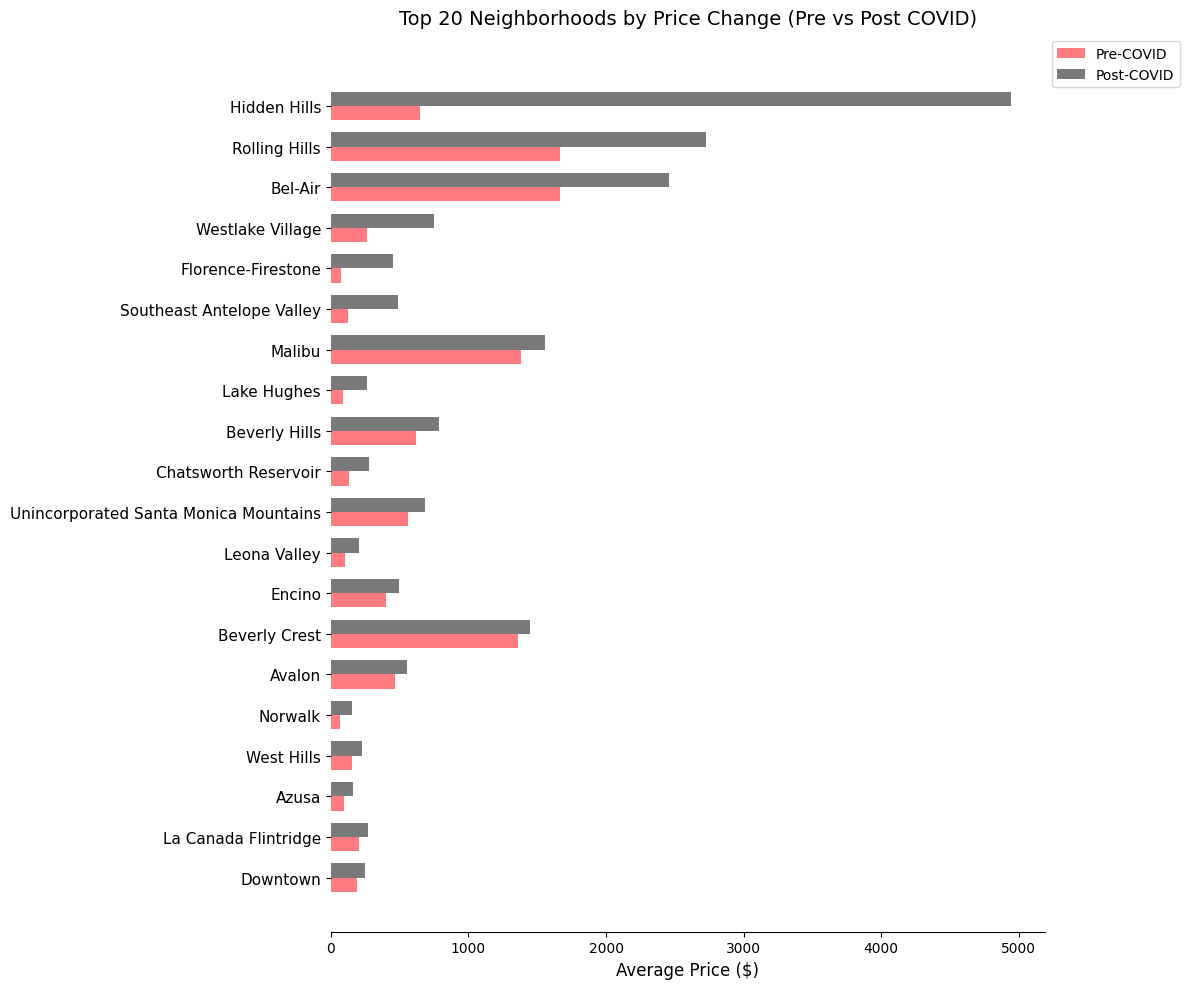


Neighborhood Price Change Summary (Top 20 by Absolute Increase):
                        Neighbourhood  Price Pre-COVID  Price Post-COVID  Price Difference  Percent Change (%)
                         Hidden Hills           650.00           4940.00           4290.00              660.00
                        Rolling Hills          1667.25           2729.94           1062.69               63.74
                              Bel-Air          1662.16           2455.81            793.65               47.75
                     Westlake Village           266.05            751.45            485.40              182.45
                   Florence-Firestone            73.60            452.08            378.48              514.22
            Southeast Antelope Valley           122.47            491.58            369.11              301.38
                               Malibu          1380.02           1554.52            174.50               12.64
                          Lake Hughes         

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Calculate average prices by neighborhood (pre and post COVID)
pre_neigh_price = pre_cov.groupby('neighbourhood')['price'].mean().reset_index()
post_neigh_price = post_cov.groupby('neighbourhood')['price'].mean().reset_index()

# Step 2: Merge the two sets
neigh_price_comparison = pd.merge(
    pre_neigh_price,
    post_neigh_price,
    on='neighbourhood',
    suffixes=('_Pre', '_Post')
)

# Step 3: Compute absolute and relative change
neigh_price_comparison['Price_Difference'] = neigh_price_comparison['price_Post'] - neigh_price_comparison['price_Pre']
neigh_price_comparison['Percent_Change'] = (neigh_price_comparison['Price_Difference'] / neigh_price_comparison['price_Pre']) * 100

# Step 4: Select top 20 neighborhoods by absolute price increase
top_20_neighborhoods = neigh_price_comparison.nlargest(20, 'Price_Difference')

# Step 5: Sort for plot (smallest at bottom, largest on top)
top_20_neighborhoods = top_20_neighborhoods.sort_values('Price_Difference', ascending=True)

# Step 6: Create the horizontal bar chart
plt.figure(figsize=(12, 10))
y_pos = range(len(top_20_neighborhoods))

plt.barh(y_pos, top_20_neighborhoods['price_Pre'], height=0.35,
         align='center', color='#FF5A5F', alpha=0.8, label='Pre-COVID')
plt.barh([x + 0.35 for x in y_pos], top_20_neighborhoods['price_Post'],
         height=0.35, align='center', color='#58585A', alpha=0.8, label='Post-COVID')

plt.yticks([x + 0.175 for x in y_pos], top_20_neighborhoods['neighbourhood'], fontsize=11)
plt.xlabel('Average Price ($)', fontsize=12)
plt.title('Top 20 Neighborhoods by Price Change (Pre vs Post COVID)', fontsize=14, pad=20)
plt.legend(bbox_to_anchor=(1, 1.02), loc='upper left')
plt.grid(False)
sns.despine(left=True)
plt.tight_layout()
plt.show()

# Step 7: Output summary statistics with renamed columns and sorted descending
summary_stats = top_20_neighborhoods.copy()
summary_stats = summary_stats.rename(columns={
    'neighbourhood': 'Neighbourhood',
    'price_Pre': 'Price Pre-COVID',
    'price_Post': 'Price Post-COVID',
    'Price_Difference': 'Price Difference',
    'Percent_Change': 'Percent Change (%)'
})

summary_stats = summary_stats.sort_values('Price Difference', ascending=False)
print("\nNeighborhood Price Change Summary (Top 20 by Absolute Increase):")
print(summary_stats[['Neighbourhood', 'Price Pre-COVID', 'Price Post-COVID', 'Price Difference', 'Percent Change (%)']].round(2).to_string(index=False))


### **2.4.3 Priority Neighborhoods: Pandemic-Era Pricing Shifts**

This section focuses on 12 high-interest LA neighborhoods, showing Airbnb price shifts during the COVID period (Mar 2020 – Jan 2021):

- **Resilient urban performance**: Core districts like **Downtown (+\$64)**, **Venice (+\$36)**, and **Los Feliz (+\$27)** led gains, reflecting **sustained interest in centrally located, culturally vibrant neighborhoods** despite ongoing uncertainty.

- **Moderate appreciation in trendy zones**: **Studio City, West Hollywood, Beverly Grove, and Silver Lake** each saw **\$10–\$25 increases**, suggesting a **measured uptick in demand** in lifestyle-focused, walkable areas.

- **Affordable areas catching up**: **West Adams, Koreatown, and Highland Park**, traditionally more affordable, showed **modest but positive changes**, signaling **gradual resilience and interest from price-sensitive renters**.

- **Softness in Echo Park**: The only neighborhood to experience a slight decline (**-\$2 or -1.5%**), possibly due to **local saturation or shifting renter preferences**.

This cluster of neighborhoods reflects a **balanced pandemic-era trend**, with **no dramatic spikes**, but clear signals of persistent demand in both central and up-and-coming areas.

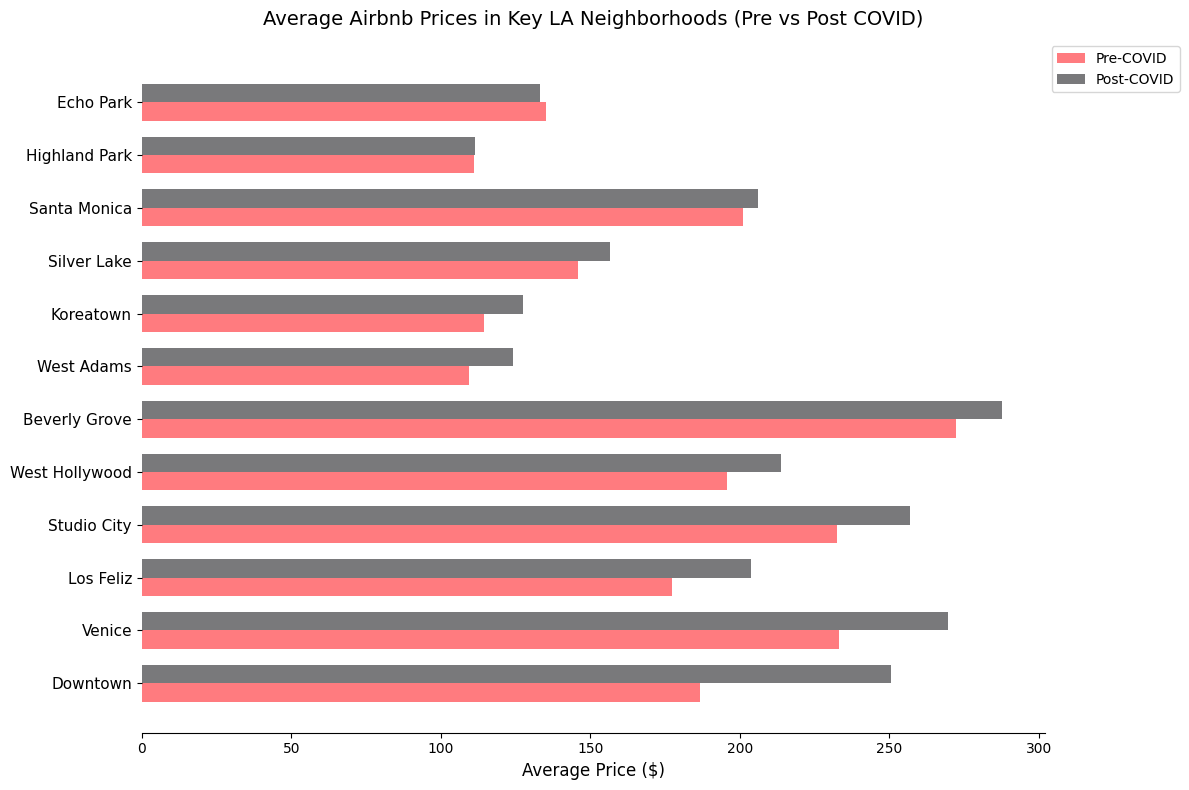

Neighborhood Price Change Summary (Priority LA Areas):
 neighbourhood  price_Pre  price_Post  Price_Difference  Percent_Change
      Downtown     186.61      250.54             63.94           34.26
        Venice     233.11      269.53             36.42           15.62
     Los Feliz     177.38      203.94             26.55           14.97
   Studio City     232.49      256.80             24.31           10.46
West Hollywood     195.71      213.95             18.24            9.32
 Beverly Grove     272.34      287.57             15.23            5.59
    West Adams     109.48      124.06             14.57           13.31
     Koreatown     114.34      127.43             13.08           11.44
   Silver Lake     146.04      156.52             10.48            7.17
  Santa Monica     201.09      206.21              5.12            2.55
 Highland Park     111.17      111.57              0.40            0.36
     Echo Park     135.16      133.17             -1.99           -1.48


In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define your core Airbnb neighborhoods
priority_hoods = [
    'Venice', 'Santa Monica', 'West Hollywood', 'Silver Lake', 'Echo Park',
    'Downtown', 'Koreatown', 'Beverly Grove', 'West Adams', 'Highland Park',
    'Studio City', 'Los Feliz'
]

# Filter summary-based pricing data
filtered_price_df = summary_df[summary_df['neighbourhood'].isin(priority_hoods)].copy()

# Ensure scrape_date is datetime
filtered_price_df['scrape_date'] = pd.to_datetime(filtered_price_df['scrape_date'])

# Split into pre and post COVID
pre_covid = filtered_price_df[(filtered_price_df['scrape_date'] >= '2018-01-01') & (filtered_price_df['scrape_date'] <= '2020-01-31')]
post_covid = filtered_price_df[(filtered_price_df['scrape_date'] >= '2020-02-01') & (filtered_price_df['scrape_date'] <= '2021-01-31')]

# Average price by neighborhood
pre_neigh_price = pre_covid.groupby('neighbourhood')['price'].mean().reset_index()
post_neigh_price = post_covid.groupby('neighbourhood')['price'].mean().reset_index()

# Merge and calculate change
neigh_price_change = pd.merge(pre_neigh_price, post_neigh_price, on='neighbourhood', suffixes=('_Pre', '_Post'))
neigh_price_change['Price_Difference'] = neigh_price_change['price_Post'] - neigh_price_change['price_Pre']
neigh_price_change['Percent_Change'] = (neigh_price_change['Price_Difference'] / neigh_price_change['price_Pre']) * 100

# Sort by price difference
top_neighs = neigh_price_change.sort_values(by='Price_Difference', ascending=False)

# Visualization
plt.figure(figsize=(12, 8))
y_pos = range(len(top_neighs))

plt.barh(y_pos, top_neighs['price_Pre'], height=0.35,
         align='center', color='#FF5A5F', alpha=0.8, label='Pre-COVID')
plt.barh([x + 0.35 for x in y_pos], top_neighs['price_Post'],
         height=0.35, align='center', color='#58585A', alpha=0.8, label='Post-COVID')

# Labeling
plt.yticks([x + 0.175 for x in y_pos], top_neighs['neighbourhood'], fontsize=11)
plt.xlabel('Average Price ($)', fontsize=12)
plt.title('Average Airbnb Prices in Key LA Neighborhoods (Pre vs Post COVID)', fontsize=14, pad=20)
plt.legend(bbox_to_anchor=(1, 1.02), loc='upper left')
plt.grid(False)
sns.despine(left=True)
plt.tight_layout()
plt.show()

# Summary Table
summary_stats = top_neighs[['neighbourhood', 'price_Pre', 'price_Post', 'Price_Difference', 'Percent_Change']]
print("Neighborhood Price Change Summary (Priority LA Areas):")
print(summary_stats.round(2).to_string(index=False))

## **2.5 Cancellation Policy Distribution During COVID**

This chart shows the distribution of Airbnb cancellation policies before and during COVID.

**Key findings:**

- **Stricter policies declined**: The use of 'Strict' cancellation terms dropped sharply from **42.6% pre-COVID to 21.0% during COVID**, indicating hosts became more lenient to attract uncertain guests.
- **Flexible & Moderate policies also declined**:
  - 'Flexible' dropped from **29.6% to 15.0%**
  - 'Moderate' dropped from **27.3% to 13.0%**  
  This suggests a general reduction in the use of standard host-defined policies.
- **'Other' category surged**: Many listings switched to Airbnb-defined or custom policies, reflecting platform adaptations during the pandemic.

**Takeaway**: During COVID, Airbnb listings increasingly relied on platform-driven cancellation policies rather than strict or flexible terms defined by hosts. This reflects a shift toward **platform standardization and guest reassurance**.


<Figure size 1200x700 with 0 Axes>

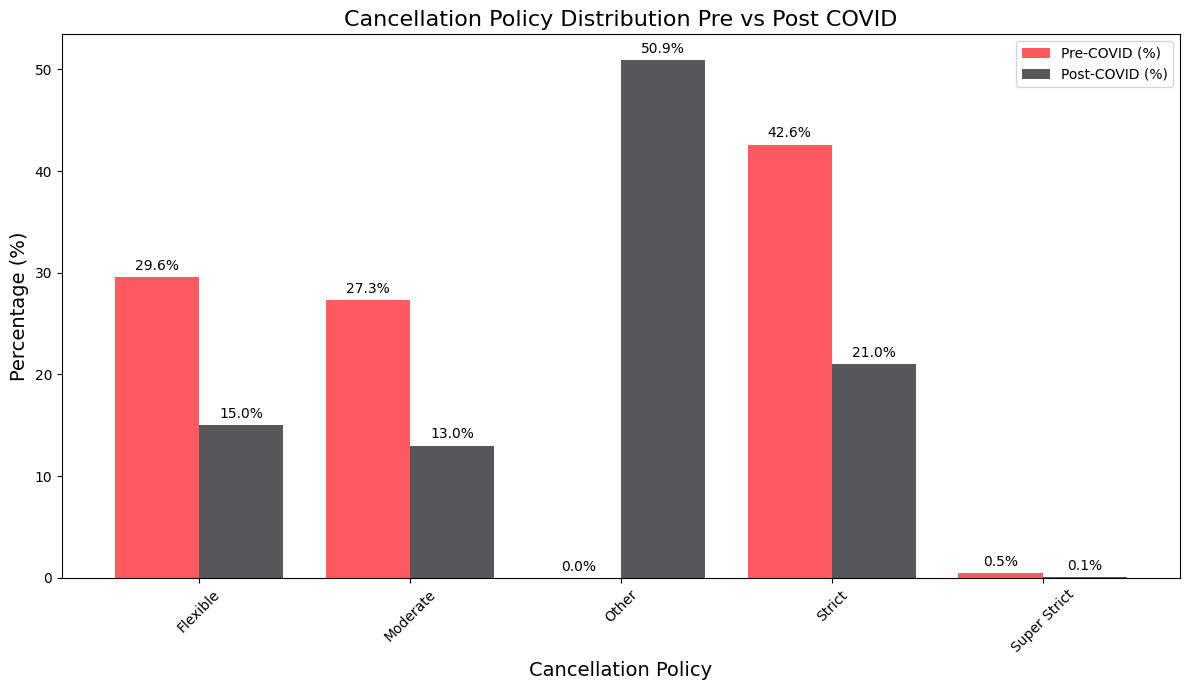

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Create plot with specified size
plt.figure(figsize=(12, 7))

# Calculate percentages
pre_covid_cancellation = pre_covid_df['cancellation_policy_cleaned'].value_counts(normalize=True) * 100
post_covid_cancellation = post_covid_df['cancellation_policy_cleaned'].value_counts(normalize=True) * 100

# Create DataFrame excluding 'No Refund' only
cancellation_df = pd.DataFrame({
   'Pre-COVID (%)': pre_covid_cancellation,
   'Post-COVID (%)': post_covid_cancellation
}).fillna(0).round(1)
cancellation_df = cancellation_df[~cancellation_df.index.isin(['No Refund'])]

# Plot bars
ax = cancellation_df.plot(kind='bar', width=0.8, color=['#FF5A5F', '#58585A'], figsize=(12, 7))

# Add percentage labels on top of bars
for container in ax.containers:
   ax.bar_label(container, fmt='%.1f%%', padding=3)

plt.title('Cancellation Policy Distribution Pre vs Post COVID', fontsize=16)
plt.ylabel('Percentage (%)', fontsize=14)
plt.xlabel('Cancellation Policy', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## **2.6 Average Cleanliness Score Over Time**

This line chart tracks the **average cleanliness score** for LA Airbnb listings from 2018 through early 2021, segmented by pre- and during-COVID periods.

**Pre-COVID trend**: Cleanliness scores steadily improved, peaking around **7.52** in mid-2019 — possibly due to rising guest expectations and host competition.

**Pandemic-period decline**: Despite increased focus on hygiene, scores **fell to a low of 7.05 by early 2021**, a **6.2% drop from peak**. This may reflect:
- Operational strain on hosts during COVID.
- Stricter guest expectations after Airbnb’s enhanced cleaning protocols.
- Surge of new, less experienced hosts entering the market.

**Takeaway**: While hosts initially improved cleanliness scores, the pandemic period saw a **perceived dip in quality**, suggesting trust and consistency in hygiene became harder to maintain.


/tmp/ipython-input-17-1048157774.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pre_covid_df['last_scraped'] = pd.to_datetime(pre_covid_df['last_scraped'])
/tmp/ipython-input-17-1048157774.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  post_covid_df['last_scraped'] = pd.to_datetime(post_covid_df['last_scraped'])
/tmp/ipython-input-17-1048157774.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  pre_monthly = pre_covid_df.groupby(pd.Grouper(ke

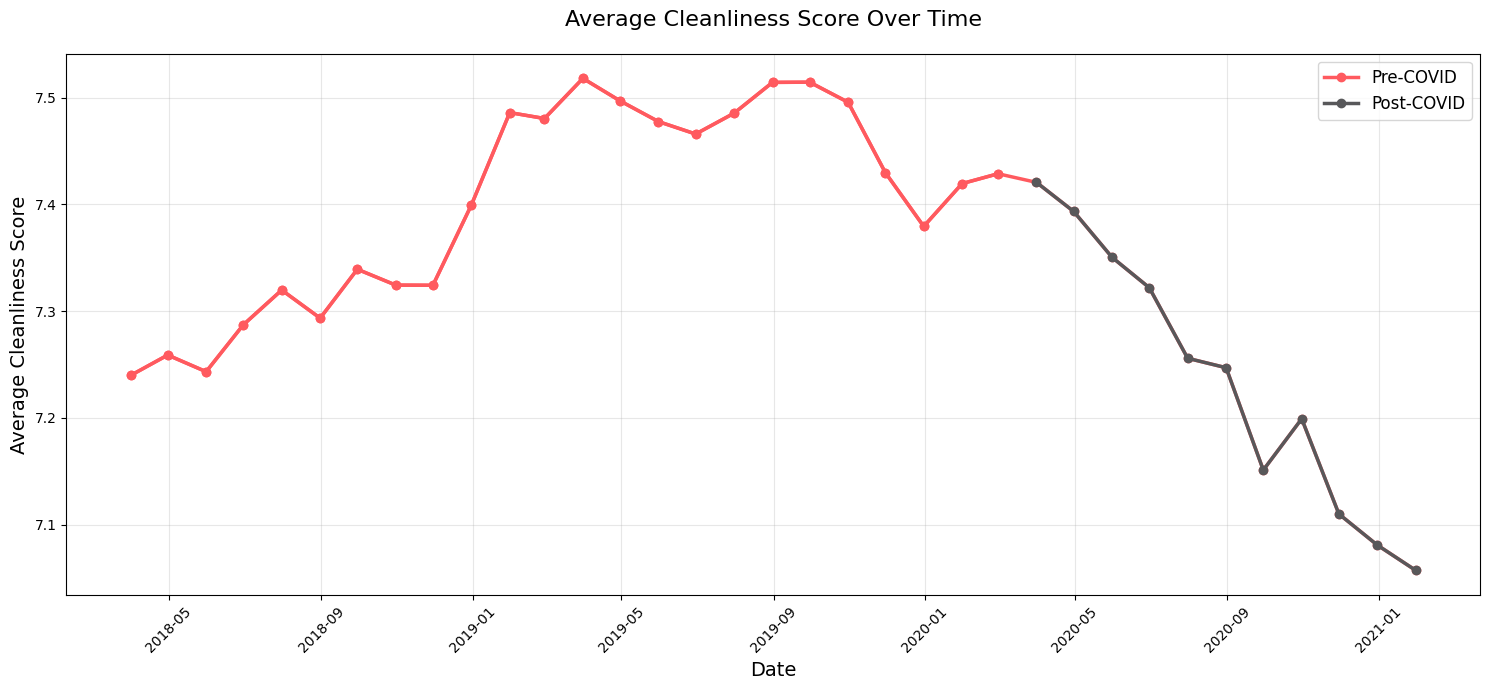


Summary Statistics:
Pre-COVID average cleanliness score: 7.40
Post-COVID average cleanliness score: 7.24
Maximum cleanliness score: 7.52
Minimum cleanliness score (post-COVID): 7.06

Percent change from peak to post-COVID low: -6.1%


In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert last_scraped to datetime if not already
pre_covid_df['last_scraped'] = pd.to_datetime(pre_covid_df['last_scraped'])
post_covid_df['last_scraped'] = pd.to_datetime(post_covid_df['last_scraped'])

# Create monthly averages for pre and post COVID periods
pre_monthly = pre_covid_df.groupby(pd.Grouper(key='last_scraped', freq='M'))['review_scores_cleanliness'].mean().reset_index()
post_monthly = post_covid_df.groupby(pd.Grouper(key='last_scraped', freq='M'))['review_scores_cleanliness'].mean().reset_index()
pre_monthly.columns = ['date', 'cleanliness']
post_monthly.columns = ['date', 'cleanliness']

# Combine into one continuous timeline
all_monthly = pd.concat([pre_monthly, post_monthly]).sort_values('date')

# Create the plot
plt.figure(figsize=(15, 7))

# Plot the entire line first
plt.plot(all_monthly['date'], all_monthly['cleanliness'],
        color='#FF5A5F', linewidth=2.5, marker='o')

# Color the segments differently
covid_start = pd.to_datetime('2020-02-01')
plt.plot(pre_monthly['date'], pre_monthly['cleanliness'],
        color='#FF5A5F', linewidth=2.5, marker='o', label='Pre-COVID')
plt.plot(post_monthly['date'], post_monthly['cleanliness'],
        color='#58585A', linewidth=2.5, marker='o', label='Post-COVID')

# Customize the plot
plt.title('Average Cleanliness Score Over Time', pad=20, fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Average Cleanliness Score', fontsize=14)

# Format axes
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Add legend
plt.legend(fontsize=12)

# Annotate peak
max_score = all_monthly['cleanliness'].max()
max_date = all_monthly.loc[all_monthly['cleanliness'].idxmax(), 'date']

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary Statistics:")
print(f"Pre-COVID average cleanliness score: {pre_monthly['cleanliness'].mean():.2f}")
print(f"Post-COVID average cleanliness score: {post_monthly['cleanliness'].mean():.2f}")
print(f"Maximum cleanliness score: {max_score:.2f}")
print(f"Minimum cleanliness score (post-COVID): {post_monthly['cleanliness'].min():.2f}")
print(f"\nPercent change from peak to post-COVID low: {((post_monthly['cleanliness'].min() - max_score) / max_score * 100):.1f}%")

## **2.7 What Makes a Listing Successful?**

### **2.7.1 Correlation Analysis Methodology**

To understand how the importance of Airbnb listing features evolved due to the COVID-19 pandemic, I conducted a side-by-side correlation analysis across two key periods:

- **Pre-COVID**: January 1, 2018 – February 29, 2020  
- **Post-COVID**: March 1, 2020 – January 31, 2021

### **Metric Estimation**
For both periods, I recalculated core performance metrics using raw data:
- **Estimated Bookings** = `number_of_reviews ÷ 0.70` (assuming a 70% review rate)
- **Estimated Nights Booked** = `Estimated Bookings × 5` (based on an average 5-night stay)
- **Occupancy Rate** = `Estimated Nights Booked ÷ 365`, capped at 70%

I also cleaned the price column and converted it to numeric, and mapped binary fields like `host_is_superhost` (`t` = 1, `f` = 0).

### **Correlation Computation**
I computed Pearson correlations between `occupancy_rate` and all numeric listing features for each period separately.

To ensure accuracy:
- I dropped non-numeric and derived columns such as `reviews_per_month`, `listing_success_score`, and `month`.  
- I applied **median imputation** to fill in missing values.

### **Visualization Approach**
To visualize the shifts in feature importance, I created three heatmaps:
1. **Pre-COVID Correlation Matrix**
2. **Post-COVID Correlation Matrix**
3. **Change in Correlations** (Post – Pre)

I also isolated and ranked the top changes in correlation with `occupancy_rate` to highlight the most actionable insights.

### **2.7.2 Correlation Analysis: Pre vs Post COVID**

This analysis reveals how the **importance of listing attributes changed** as travel behavior evolved during the pandemic.

### **Key Findings**

**1. Host Acceptance Rate Became Critical**
- **+0.20 increase** in correlation with occupancy rate post-COVID  
- Guests prioritized **flexible, responsive hosts**  
- Listings with rigid booking rules or slow responses were booked less often

**2. Review Scores Consistently Predict Success**
- Cleanliness, communication, location, and value each held a **~0.50 correlation** with occupancy  
- High-rated listings remained **resilient** even during downturns

**3. Superhost Status Still Matters**
- Maintained a **0.40+ correlation** with occupancy  
- Continued to serve as a **trust signal** for reliability

**4. Price Sensitivity Declined**
- Correlation between price and occupancy was **flat or negligible**  
- Guests favored **clean, dependable listings** over cheaper options  
- Booking behavior shifted from **discount-driven** to **value-driven**

---

### **Strategic Takeaways for Hosts & Operators**

**1. Flexibility Wins**
- High acceptance rates and **lenient cancellation policies** led to stronger occupancy  
- Quick response times and guest-friendly terms became critical

**2. Quality Drives Demand**
- Listings with strong review scores — especially for cleanliness and communication — performed better

**3. Suburban Shift**
- Demand migrated to **lower-density, remote-friendly neighborhoods**  
- Fringe areas outperformed dense urban cores

**4. Professional Hosts Must Adapt**
- **Individual hosts** achieved better occupancy than large-scale operators  
- Personalized hosting remains a **competitive advantage**

---

### **Summary**

This correlation framework helped surface **evidence-based insights** about what drives listing performance — not just in a stable market, but during a period of global uncertainty.

By re-estimating occupancy and analyzing correlation shifts before and after COVID, I derived practical guidance for:
- Airbnb hosts looking to optimize bookings  
- Platforms aiming to surface high-performance listings  
- Urban policymakers monitoring short-term rental trends

Pre-COVID columns: ['price', 'availability_365', 'reviews_per_month', 'latitude', 'longitude', 'minimum_nights', 'calculated_host_listings_count', 'number_of_reviews', 'host_is_superhost', 'host_response_rate', 'host_acceptance_rate', 'accommodates', 'review_scores_rating', 'review_scores_cleanliness', 'review_scores_location', 'review_scores_value', 'review_scores_communication', 'estimated_bookings', 'estimated_nights_booked', 'occupancy_rate']
Post-COVID columns: ['price', 'availability_365', 'reviews_per_month', 'latitude', 'longitude', 'minimum_nights', 'calculated_host_listings_count', 'number_of_reviews', 'host_is_superhost', 'host_response_rate', 'host_acceptance_rate', 'accommodates', 'review_scores_rating', 'review_scores_cleanliness', 'review_scores_location', 'review_scores_value', 'review_scores_communication', 'estimated_bookings', 'estimated_nights_booked', 'occupancy_rate']
Occupancy rate in pre-COVID: True
Occupancy rate in post-COVID: True


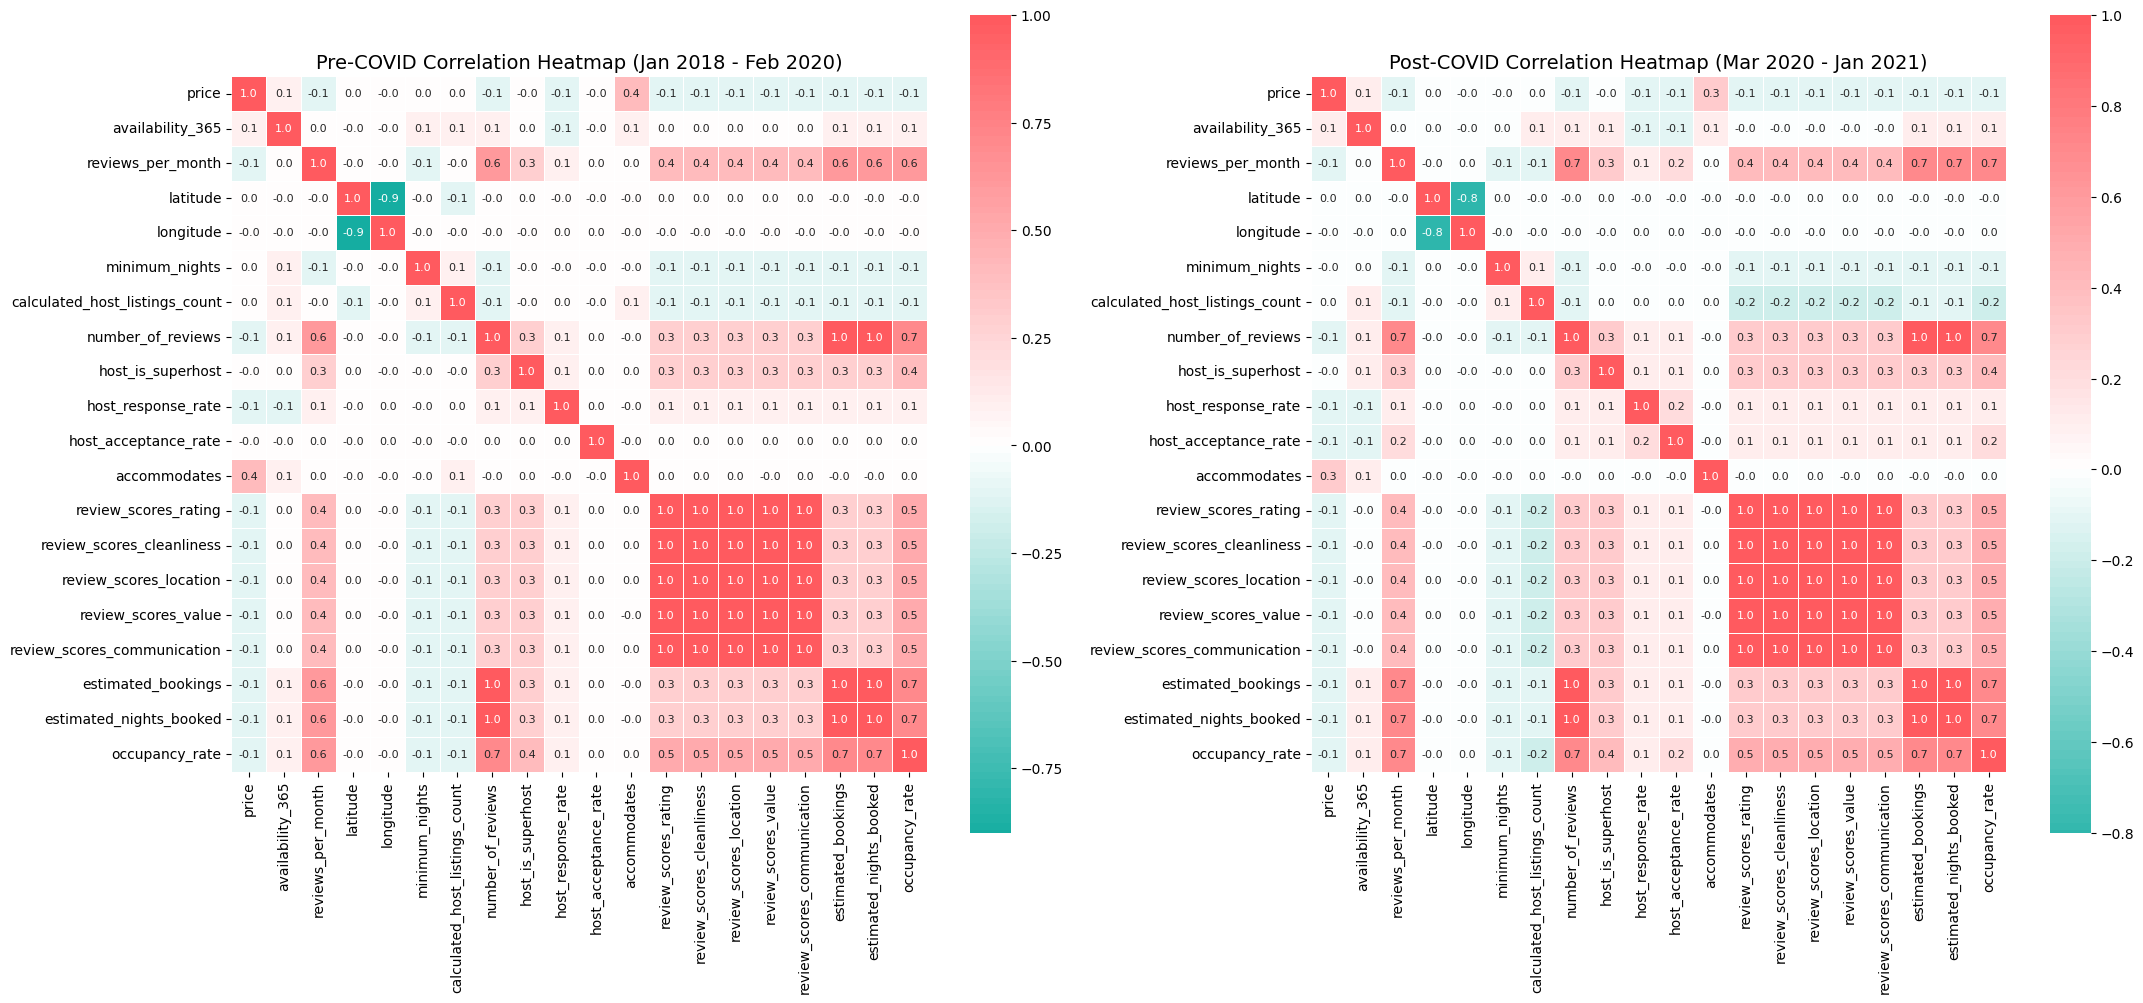

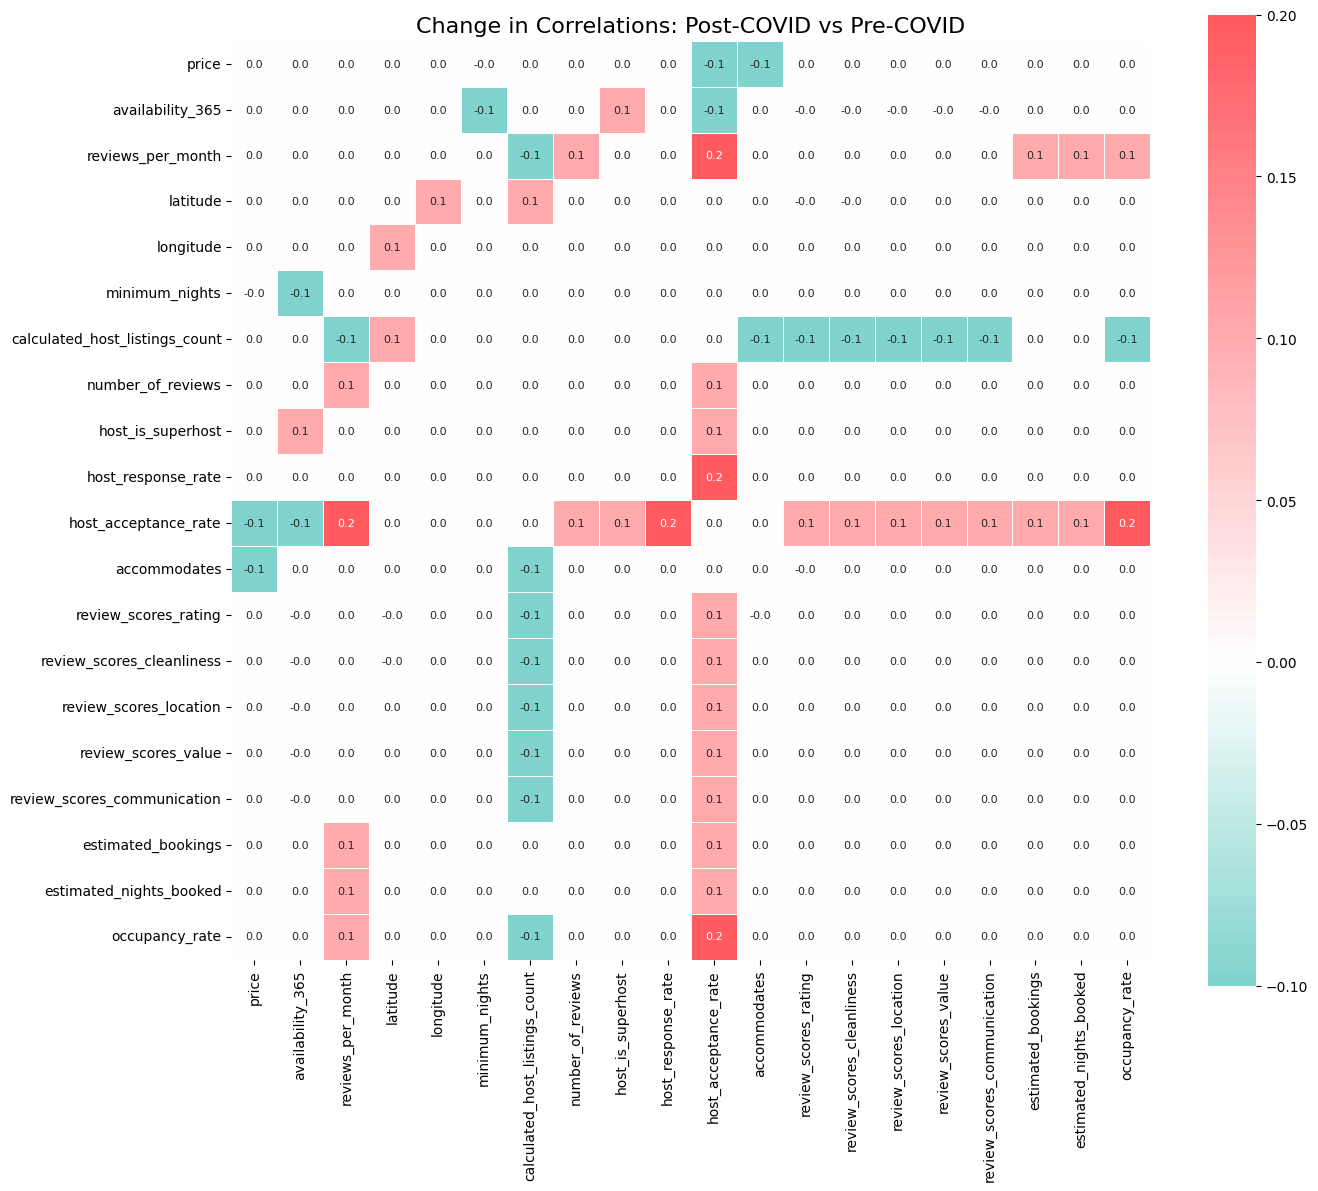

Top changes in correlation with occupancy rate:
host_acceptance_rate              0.2
reviews_per_month                 0.1
availability_365                  0.0
price                             0.0
latitude                          0.0
longitude                         0.0
number_of_reviews                 0.0
minimum_nights                    0.0
host_response_rate                0.0
host_is_superhost                 0.0
accommodates                      0.0
review_scores_rating              0.0
review_scores_communication       0.0
review_scores_cleanliness         0.0
review_scores_location            0.0
review_scores_value               0.0
estimated_nights_booked           0.0
estimated_bookings                0.0
occupancy_rate                    0.0
calculated_host_listings_count   -0.1
Name: occupancy_rate, dtype: float64


In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define Airbnb colors
RAUSCH = "#FF5A5F"  # Red
BABU = "#00A699"    # Teal
ARCHES = "#FC642D"  # Orange
HOF = "#484848"     # Gray
FOGGY = "#767676"   # Light gray

# Create custom colormap function
def create_custom_colormap():
    colors = [BABU, "#FFFFFF", RAUSCH]
    return mcolors.LinearSegmentedColormap.from_list('custom_cmap', colors, N=100)

# Filter data into pre and post COVID periods
pre_covid_df = clean_df[(clean_df['last_scraped'] >= '2018-01-01') & (clean_df['last_scraped'] <= '2020-02-29')].copy()
post_covid_df = clean_df[(clean_df['last_scraped'] >= '2020-03-01') & (clean_df['last_scraped'] <= '2021-01-31')].copy()

# COMPLETE RECALCULATION FOR PRE-COVID
# Calculate all metrics from scratch for pre-COVID
REVIEW_RATE = 0.70
AVG_STAY_LENGTH = 5

# Pre-COVID calculations
pre_covid_df['price'] = pd.to_numeric(pre_covid_df['price'].replace('[\$,]', '', regex=True), errors='coerce')
pre_covid_df['host_is_superhost'] = pre_covid_df['host_is_superhost'].map({'t': 1, 'f': 0})

# Calculate metrics
pre_covid_df['estimated_bookings'] = pre_covid_df['number_of_reviews'] / REVIEW_RATE
pre_covid_df['estimated_nights_booked'] = pre_covid_df['estimated_bookings'] * AVG_STAY_LENGTH
pre_covid_df['occupancy_rate'] = (pre_covid_df['estimated_nights_booked'] / 365) * 100
pre_covid_df['occupancy_rate'] = pre_covid_df['occupancy_rate'].clip(upper=70)

# Select numeric columns and fill missing values
pre_covid_numeric = pre_covid_df.select_dtypes(include=[np.number])
pre_covid_numeric = pre_covid_numeric.fillna(pre_covid_numeric.median())

# COMPLETE RECALCULATION FOR POST-COVID
# Post-COVID calculations
post_covid_df['price'] = pd.to_numeric(post_covid_df['price'].replace('[\$,]', '', regex=True), errors='coerce')
post_covid_df['host_is_superhost'] = post_covid_df['host_is_superhost'].map({'t': 1, 'f': 0})

# Calculate metrics
post_covid_df['estimated_bookings'] = post_covid_df['number_of_reviews'] / REVIEW_RATE
post_covid_df['estimated_nights_booked'] = post_covid_df['estimated_bookings'] * AVG_STAY_LENGTH
post_covid_df['occupancy_rate'] = (post_covid_df['estimated_nights_booked'] / 365) * 100
post_covid_df['occupancy_rate'] = post_covid_df['occupancy_rate'].clip(upper=70)

# Select numeric columns and fill missing values
post_covid_numeric = post_covid_df.select_dtypes(include=[np.number])
post_covid_numeric = post_covid_numeric.fillna(post_covid_numeric.median())

# Remove derived columns if needed, but keep occupancy rate
columns_to_drop = ['estimated_revenue', 'listing_success_score', 'month', 'year', 'num_bathrooms']
pre_covid_numeric = pre_covid_numeric.drop(columns=columns_to_drop, errors='ignore')
post_covid_numeric = post_covid_numeric.drop(columns=columns_to_drop, errors='ignore')

# Check that occupancy_rate is in both dataframes
print("Pre-COVID columns:", pre_covid_numeric.columns.tolist())
print("Post-COVID columns:", post_covid_numeric.columns.tolist())
print("Occupancy rate in pre-COVID:", 'occupancy_rate' in pre_covid_numeric.columns)
print("Occupancy rate in post-COVID:", 'occupancy_rate' in post_covid_numeric.columns)

# Calculate correlations
pre_covid_corr = pre_covid_numeric.corr().round(1)
post_covid_corr = post_covid_numeric.corr().round(1)

# Ensure both have the same columns for comparison
common_cols = pre_covid_corr.columns.intersection(post_covid_corr.columns)
pre_covid_corr = pre_covid_corr.loc[common_cols, common_cols]
post_covid_corr = post_covid_corr.loc[common_cols, common_cols]

# Create custom colormap
custom_cmap = create_custom_colormap()

# Create figures for both heatmaps
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 10))

# Pre-COVID heatmap
sns.heatmap(pre_covid_corr, annot=True, cmap=custom_cmap, center=0,
            square=True, linewidths=0.5, fmt=".1f", annot_kws={"size": 8},
            ax=ax1)
ax1.set_title('Pre-COVID Correlation Heatmap (Jan 2018 - Feb 2020)', fontsize=14)

# Post-COVID heatmap
sns.heatmap(post_covid_corr, annot=True, cmap=custom_cmap, center=0,
            square=True, linewidths=0.5, fmt=".1f", annot_kws={"size": 8},
            ax=ax2)
ax2.set_title('Post-COVID Correlation Heatmap (Mar 2020 - Jan 2021)', fontsize=14)

plt.tight_layout()
plt.show()

# Compute and display correlation differences
diff_corr = (post_covid_corr - pre_covid_corr).round(1)

plt.figure(figsize=(14, 12))
sns.heatmap(diff_corr, annot=True, cmap=custom_cmap, center=0,
            square=True, linewidths=0.5, fmt=".1f", annot_kws={"size": 8})
plt.title('Change in Correlations: Post-COVID vs Pre-COVID', fontsize=16)
plt.tight_layout()
plt.show()

# Print top changes in correlation with occupancy_rate
if 'occupancy_rate' in diff_corr.columns:
    occupancy_changes = diff_corr['occupancy_rate'].sort_values(ascending=False)
    print("Top changes in correlation with occupancy rate:")
    print(occupancy_changes)
else:
    print("occupancy_rate column not found in the difference matrix")


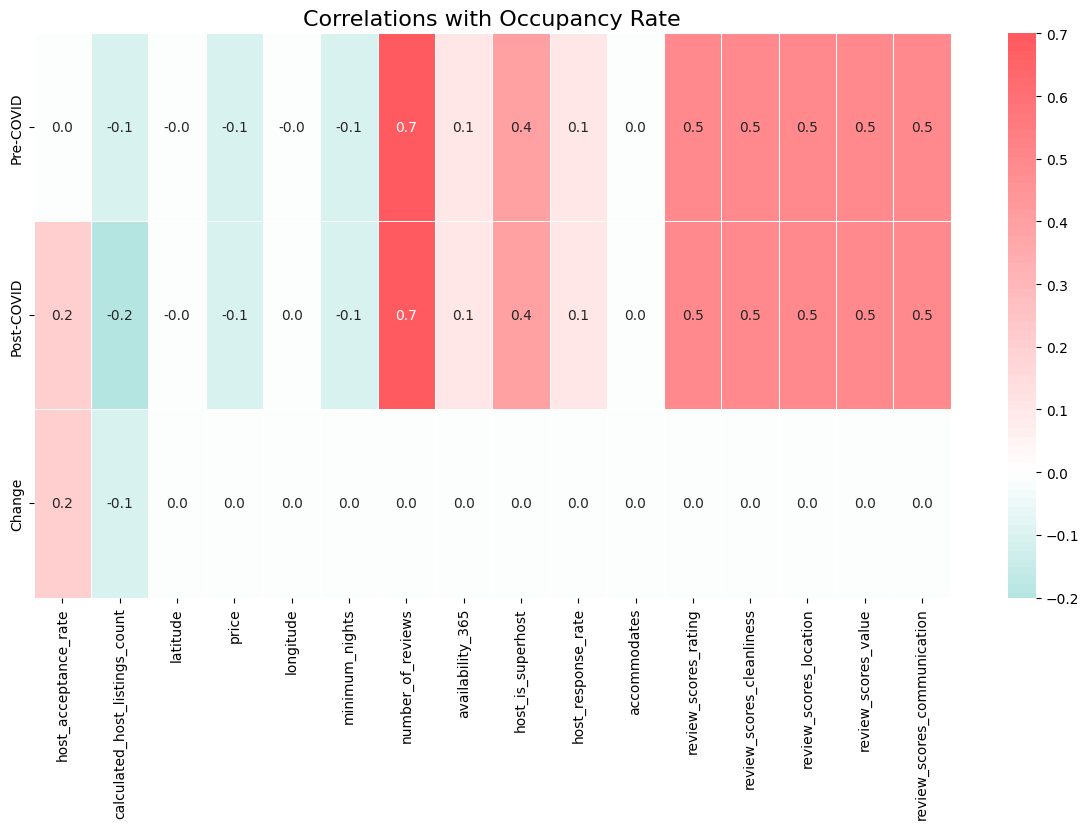


CORRELATIONS WITH OCCUPANCY RATE:
                                Pre-COVID  Post-COVID  Change
host_acceptance_rate                  0.0         0.2     0.2
calculated_host_listings_count       -0.1        -0.2    -0.1
latitude                             -0.0        -0.0     0.0
price                                -0.1        -0.1     0.0
longitude                            -0.0         0.0     0.0
minimum_nights                       -0.1        -0.1     0.0
number_of_reviews                     0.7         0.7     0.0
availability_365                      0.1         0.1     0.0
host_is_superhost                     0.4         0.4     0.0
host_response_rate                    0.1         0.1     0.0
accommodates                          0.0         0.0     0.0
review_scores_rating                  0.5         0.5     0.0
review_scores_cleanliness             0.5         0.5     0.0
review_scores_location                0.5         0.5     0.0
review_scores_value                

In [19]:
# Extract just the correlations with occupancy_rate
if 'occupancy_rate' in pre_covid_corr.columns and 'occupancy_rate' in post_covid_corr.columns:
    # Get correlations with occupancy_rate (excluding itself)
    pre_covid_occupancy_corr = pre_covid_corr['occupancy_rate'].drop('occupancy_rate')
    post_covid_occupancy_corr = post_covid_corr['occupancy_rate'].drop('occupancy_rate')

    # Calculate the differences
    diff_occupancy_corr = post_covid_occupancy_corr - pre_covid_occupancy_corr

    # Create a DataFrame just for occupancy_rate correlations
    occupancy_corr_df = pd.DataFrame({
        'Pre-COVID': pre_covid_occupancy_corr,
        'Post-COVID': post_covid_occupancy_corr,
        'Change': diff_occupancy_corr
    })

    # Remove any rows we want to exclude (e.g., derived columns and reviews_per_month)
    exclude_cols = ['estimated_bookings', 'estimated_nights_booked', 'reviews_per_month']
    occupancy_corr_df = occupancy_corr_df.drop(index=exclude_cols, errors='ignore')

    # Sort by the absolute value of the change
    occupancy_corr_df = occupancy_corr_df.sort_values(by='Change', key=abs, ascending=False)

    # Create a heatmap just for occupancy rate correlations
    plt.figure(figsize=(12, len(occupancy_corr_df) * 0.4 + 2))

    # Convert to a format suitable for heatmap (just one column)
    heatmap_df = occupancy_corr_df.T

    # Create the heatmap
    sns.heatmap(heatmap_df, annot=True, cmap=custom_cmap, center=0,
                linewidths=0.5, fmt=".1f", annot_kws={"size": 10})

    plt.title('Correlations with Occupancy Rate', fontsize=16)
    plt.tight_layout()
    plt.show()

    # Print the results in a tabular format
    print("\nCORRELATIONS WITH OCCUPANCY RATE:")
    print("================================")
    print(occupancy_corr_df.round(2))

    # Add notes about the date ranges
    print("\nNote:")
    print("* Pre-Covid: Jan 1, 2018 to Feb 29, 2020")
    print("* Post-Covid: Mar 1, 2020 to Jan 31, 2021")